In [1]:
!pwd

/Users/wiktor/Documents/repos/computer-vision-experiments


In [1]:
from PIL import Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.cluster import KMeans
import numpy as np
import random
import cv2
# from google.colab.patches import cv2_imshow


# Histograms

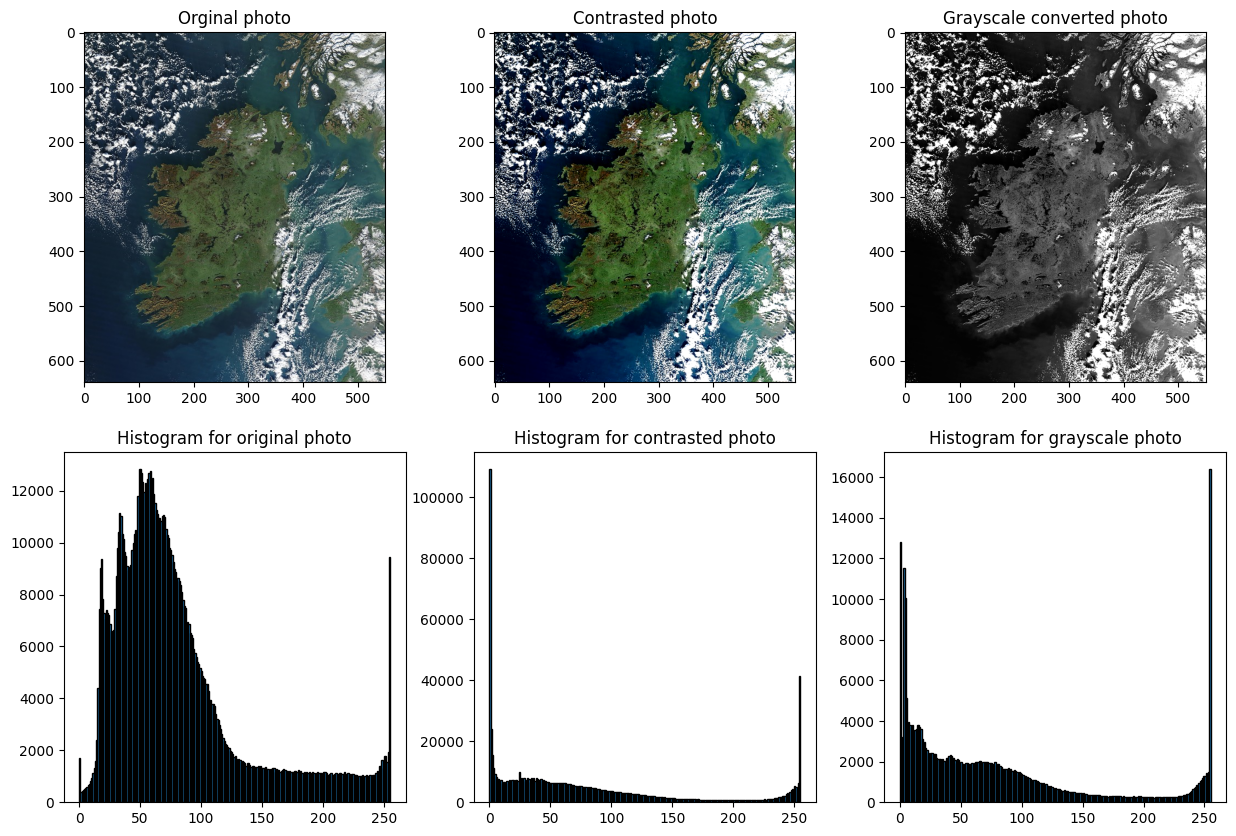

In [45]:

fig, ax = plt.subplots(2,3, figsize = (15,10))
#Load and show photos
img = Image.open('CV_files/ireland.jpg')
# add contrast to original photos to enchance visibility of clouds
enhancer = ImageEnhance.Contrast(img)
factor = 1.7
img_contrast = enhancer.enhance(factor)
img_contrast.save('CV_files/ireland_contrast.jpg')

# convert color picture to b&w
img_bnw = ImageOps.grayscale(img_contrast)
img_bnw
img_bnw.save('CV_files/ireland_bnw.jpg')

# plot photos
ax[0, 0].imshow(img)
ax[0, 0].set_title('Orginal photo')

ax[0, 1].imshow(img_contrast)
ax[0, 1].set_title('Contrasted photo')

ax[0, 2].imshow(img_bnw, cmap = 'gray')
ax[0, 2].set_title('Grayscale converted photo')

#Conver photos to arrays
image_array = imread("CV_files/ireland.jpg")
image_bnw_array = imread("CV_files/ireland_bnw.jpg")
image_contrast_array = imread("CV_files/ireland_contrast.jpg")

#Plot histograms
ax[1,0].hist(image_array.ravel(), bins = 256, ec = 'k')
ax[1,0].set_title('Histogram for original photo')

ax[1,1].hist(image_contrast_array.ravel(), bins = 256, ec = 'k')
ax[1,1].set_title('Histogram for contrasted photo')

ax[1,2].hist(image_bnw_array.ravel(), bins = 256, ec = 'k')
ax[1,2].set_title('Histogram for grayscale photo')
plt.show()
fig.savefig('output/histograms.jpg')

# Histogram normalization

In [53]:
def normalize_image(img, save_path = False):
  fig, ax = plt.subplots(2, 2, figsize = (15, 10))
  hist, bins = np.histogram (img.flatten(), 256, [0,256])
  cdf = hist.cumsum()
  cdf_normalized = cdf* float(hist.max()) / cdf.max()
  ax[0, 0].imshow(img, cmap='gray')
  ax[0, 0].set_title("original photo")

  ax[1, 0].plot(cdf_normalized, color = 'b')
  ax[1, 0].hist(img.flatten(), 256, [0,256], color = 'r')
  plt.xlim([0,256])
  ax[1, 0].set_title("Histogram of original photo")
  
  cdf_m = np.ma.masked_equal(cdf,0)
  cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
  cdf = np.ma.filled (cdf_m, 0).astype('uint8')
  img2 = cdf[img]

  ax[0, 1].imshow(img2, cmap='gray')
  ax[0, 1].set_title("Normalized photo")

  ax[1, 1].plot(cdf_normalized, color = 'b')
  ax[1, 1].hist(img2.flatten(), 256, [0,256], color = 'r')
  ax[1, 1].set_title("Histogram of original photo")
  plt.xlim([0,256])

  plt.show()
  if save_path: fig.savefig(save_path)


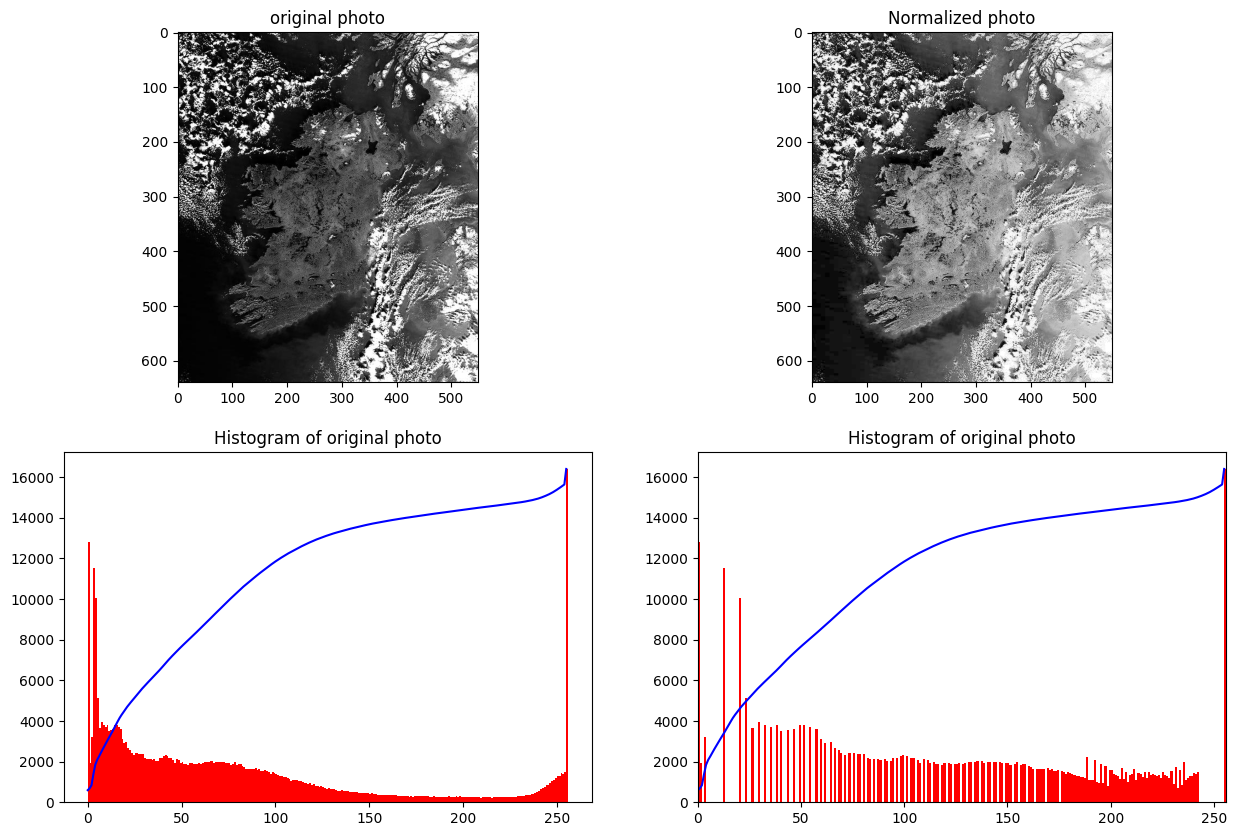

In [54]:
normalize_image(image_bnw_array, save_path='output/normalized_histogram.jpg')

In [7]:
def show_histogram(image):
  ax = plt.subplot(3, 3, 1)
  plt.xlim([0, 255])

  for i, col in enumerate(['b', 'g', 'r']):

    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    ax = plt.subplot(3,1,i+1)
    plt.plot(hist, color=col)

  plt.show()

show_histogram(image_array)

/var/folders/dz/339qlqpx101c9mwxzw8rw0hh0000gn/T/ipykernel_2300/3654111768.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3,1,i+1)


/var/folders/dz/339qlqpx101c9mwxzw8rw0hh0000gn/T/ipykernel_2300/3654111768.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3, 3, 1)
/var/folders/dz/339qlqpx101c9mwxzw8rw0hh0000gn/T/ipykernel_2300/3654111768.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3,1,i+1)


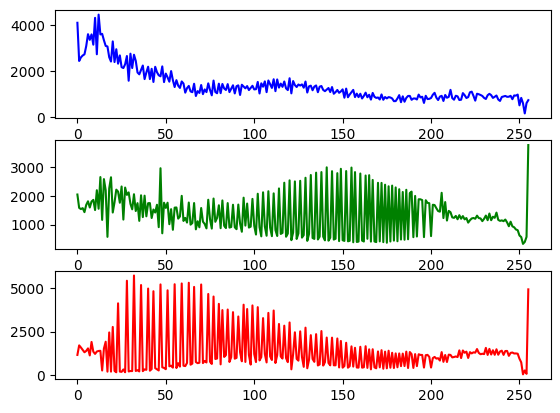

In [8]:
def show_equalized_histogram(image):
  hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  H, S, V = cv2.split(hsv_img)
  eq_V = cv2.equalizeHist(V)
  eq_image = cv2.cvtColor(cv2.merge([H, S, eq_V]), cv2.COLOR_HSV2BGR)
  plt.imshow(np.concatenate([image, eq_image], axis = 1))
  show_histogram(eq_image)

show_equalized_histogram(image_array)

# Clustering - detecing clouds on satelite photos

Implementation of K-means algorithm for two-cluster segmentation

In [9]:
reshaped = image_bnw_array.reshape(550*640, 1)
k_means = KMeans(n_clusters = 2)
k_means.fit(reshaped)

pred = k_means.predict(reshaped)
pred_reshaped = pred.reshape(640, 550)

/Users/wiktor/opt/anaconda3/envs/cv-experiments/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Plot original and segmented photos

In [51]:
def plot_transformation(img_original, img_grayscale, img_segmented, save_path = False):

    fig, ax = plt.subplots(1,3, figsize = (20,25))

    ax[0].imshow(img_original, interpolation='nearest')
    ax[0].set_title('Original photo')

    ax[1].imshow(img_grayscale, interpolation='nearest', cmap = 'gray')
    ax[1].set_title('Grayscale photo')


    ax[2].imshow(img_segmented, interpolation='nearest')
    ax[2].set_title('Segmented photo')

    plt.show()
    if save_path: fig.savefig(save_path)
        

In [52]:
plot_transformation(image_array, image_bnw_array, pred_reshaped, save_path = 'output/segmentation_1.jpg')

<BarContainer object of 2 artists>

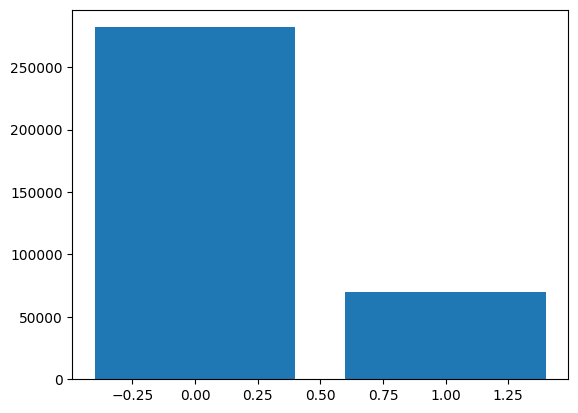

In [12]:
import numpy as np
unique, counts = np.unique(pred_reshaped, return_counts=True)

data = dict(zip(unique, counts))
clusters = list(data.keys())
counts = list(data.values())

plt.bar(clusters, counts)

## Using trained model on another aerial pictures

In [14]:
img_2 = Image.open('CV_files/nasa.jpg')

img_2_bnw = ImageOps.grayscale(img_2)
img_bnw
img_2_bnw.save('CV_files/nasa_bnw.jpg')
image_2_array = imread('CV_files/nasa.jpg')
image_2_bnw_array = imread("CV_files/nasa_bnw.jpg")

In [15]:
image_2_reshaped = image_2_bnw_array.reshape(3000*3600,1)

pred_2 = k_means.predict(image_2_reshaped)
pred_2_reshaped = pred_2.reshape(3000, 3600)

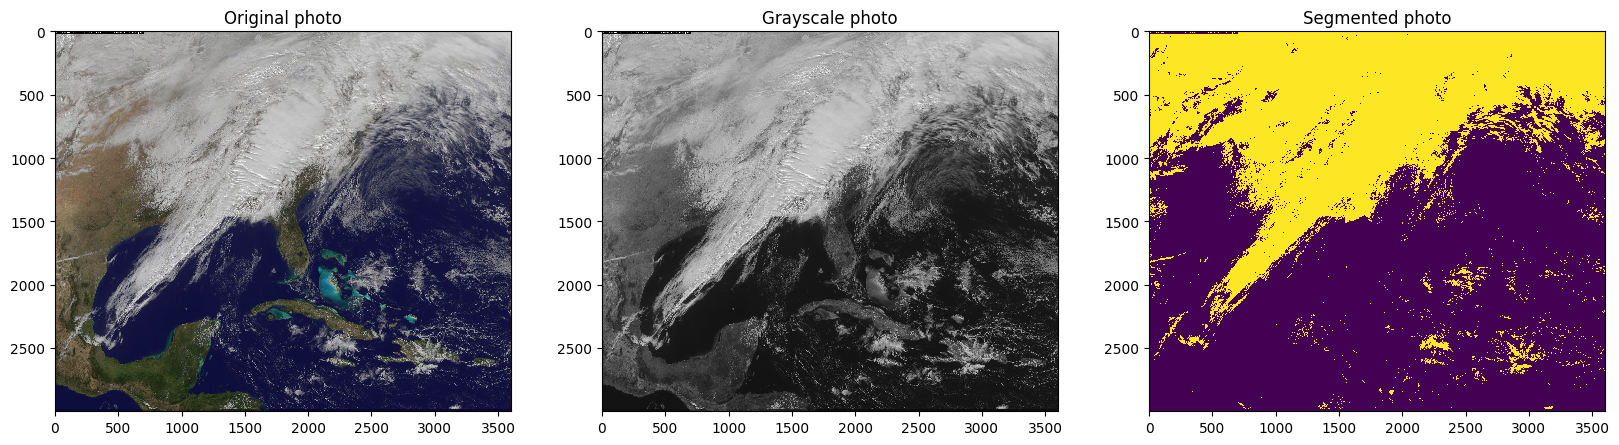

In [55]:
plot_transformation(image_2_array, image_2_bnw_array, pred_2_reshaped, save_path = 'output/segmentation_2.jpg')

In [19]:
img_3 = Image.open('CV_files/geo_2.jpg')

img_3_bnw = ImageOps.grayscale(img_3)
img_3_bnw.save('CV_files/geo_2_bnw.jpg')

image_3_array = imread('CV_files/geo_2.jpg')
image_3_bnw_array = imread("CV_files/geo_2_bnw.jpg")

In [20]:
image_3_bnw_array.shape

(521, 1024)

In [21]:
image_3_reshaped = image_3_bnw_array.reshape(521*1024,1)

pred_3 = k_means.predict(image_3_reshaped)
pred_3_reshaped = pred_3.reshape(521, 1024)

In [22]:
plot_transformation(image_3_array, image_3_bnw_array, pred_3_reshaped)

# Point operators

## Brightness operator

In [23]:
def change_brightness(image, factor):
    image_shape = image.shape
    #convert type from int8 to int as it is problematic when values exceed 255
    img = np.asarray(image.copy(), int)
    transform = lambda x: x + factor
    img = transform(img)

    #limit range of values
    img[img >= 255] = 255
    img[img <= 0] = 0
    return img    
    

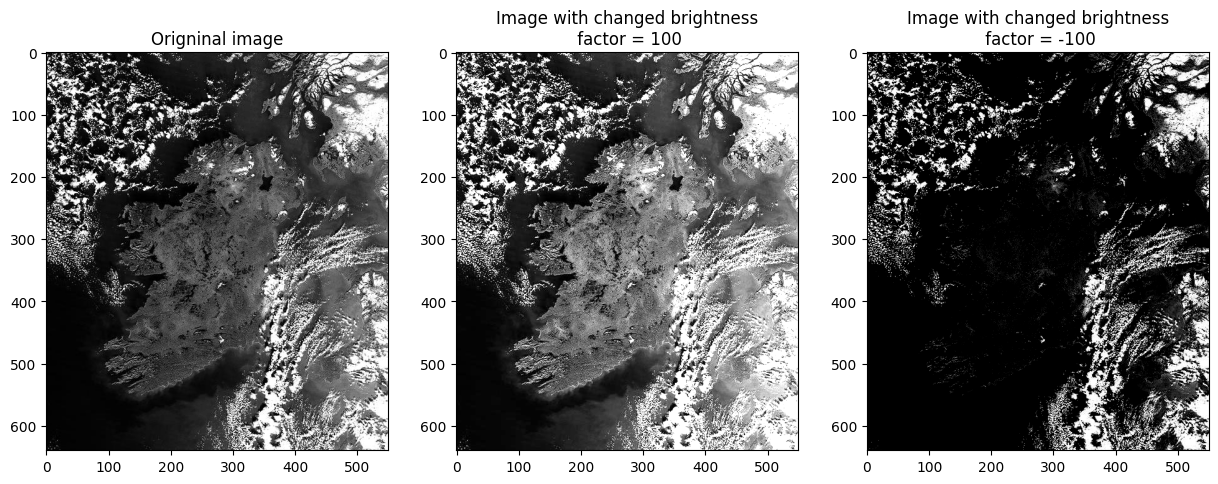

In [24]:
fig, ax = plt.subplots(1,3, figsize = (15,15))
ax[0].imshow(image_bnw_array, cmap = 'gray')
ax[0].set_title('Origninal image')
ax[1].imshow(change_brightness(image_bnw_array, 100), cmap = 'gray')
ax[1].set_title("Image with changed brightness\n factor = 100")
ax[2].imshow(change_brightness(image_bnw_array, -100), cmap = 'gray')
ax[2].set_title("Image with changed brightness\n factor = -100")
plt.show()

# Random noise generation

In [25]:

def generate_noise(image, noise_amount = 0.1):
    image = image.copy()
    img_height, img_width = image.shape[0], image.shape[1]
    image_reshaped = image.reshape(-1,1)
    
    n_of_pixels = img_height * img_width
    noise_pixels_amount = n_of_pixels * noise_amount
    
    pixels_to_change = [random.randint(0, n_of_pixels)
                        for i in range(0, int(noise_pixels_amount))]
    
    for pixel in pixels_to_change:
        image_reshaped[pixel] = random.choice([0,255])
    
    noised_image = image_reshaped.reshape(img_height, img_width)
    
    return noised_image

In [26]:
noised_image = generate_noise(image_3_bnw_array, noise_amount = 0.15)

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (20,12))
ax[0].imshow(image_3_bnw_array, cmap = 'gray')
ax[0].set_title('Grayscale image')

ax[1].imshow(noised_image, cmap = 'gray')
ax[1].set_title('Noised image')

plt.show()

# Noise reduction

In [28]:
def apply_filter(source, kernel):
  new_img = cv2.filter2D(source, -1, kernel)
  plt.imshow(new_img, cmap = 'gray')
  return new_img

In [29]:
blur_kernel = np.array([[1, 1, 1, 1],
                        [1, 1, 1, 1],
                        [1, 1, 1, 1],
                        [1, 1, 1, 1]]) * (1/16)

In [30]:
denoised = apply_filter(noised_image, blur_kernel)

In [31]:
fig, ax = plt.subplots(1, 3, figsize = (25,20))
ax[0].imshow(image_3_bnw_array, cmap = 'gray')
ax[0].set_title('Grayscale image')

ax[1].imshow(noised_image, cmap = 'gray')
ax[1].set_title('Noised image')

ax[2].imshow(denoised, cmap = 'gray')
ax[2].set_title('Denoised image')

plt.show()

# Edge detection

In [34]:
img = cv2.imread('CV_files/contours.png')

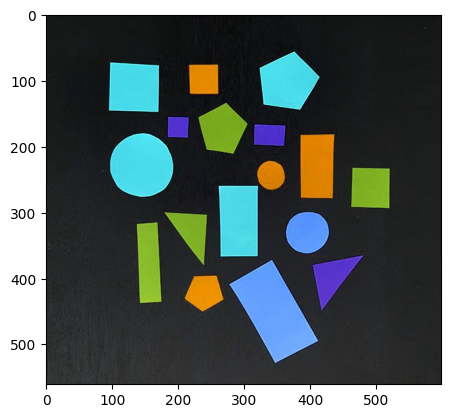

In [35]:
plt.imshow(img)
plt.show()

## Image grayscale conversion

In [36]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

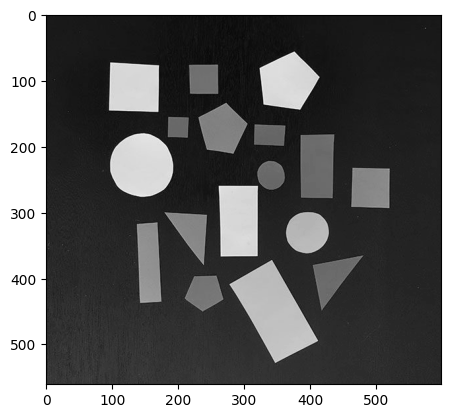

In [37]:
plt.imshow(gray, cmap = 'gray')
plt.show()

## Thresholding

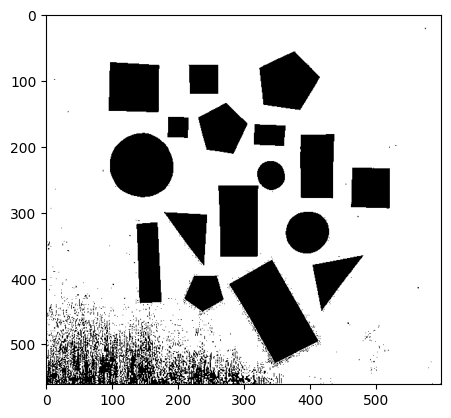

In [38]:
_, thres_img = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
plt.imshow(thres_img, cmap = 'binary')
plt.show()

## Morphological operations

To exctract details from pictures (shapes), morphological operations can be used. In this case erosion should give the best results. Using rectangular 10x10 kernel provides very high quality output with visible edges, almost without artefacts.

In [39]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
eroded = cv2.erode(thres_img, kernel)

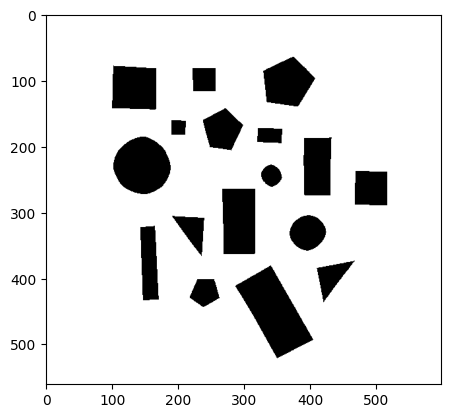

In [40]:
plt.imshow(eroded, cmap = 'binary')
plt.show()

## Finding contours

In [41]:
contours, hierarchy = cv2.findContours(eroded, 
                                       cv2.RETR_TREE, 
                                       cv2.CHAIN_APPROX_SIMPLE)

In [42]:
print(f"Number of contours found: {len(contours)}")

Number of contours found: 17


It makes sense that there are 17 contours found, since in original picture there are 17 shapes. That means that tresholding was performed sucessfully

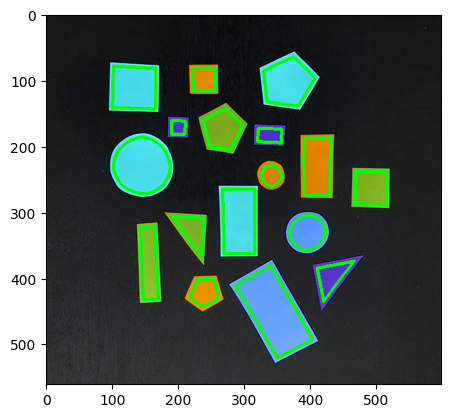

In [43]:
img2 = cv2.drawContours(img.copy(), contours, -1, (0,255,0), 3)
plt.imshow(img2)
plt.show()